In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import os
import tqdm
import heapq
import datetime
import glob
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [6]:
pwd

'C:\\Users\\deVam'

In [7]:
BASE_PATH = 'data/UCF-101'
VIDEOS_PATH = os.path.join(BASE_PATH, '**','*.avi')
FILE_SELECTOR = "**/*.avi"
SEQUENCE_LENGTH = 40

# Step 1 - Visualize Data

### Plot distribution

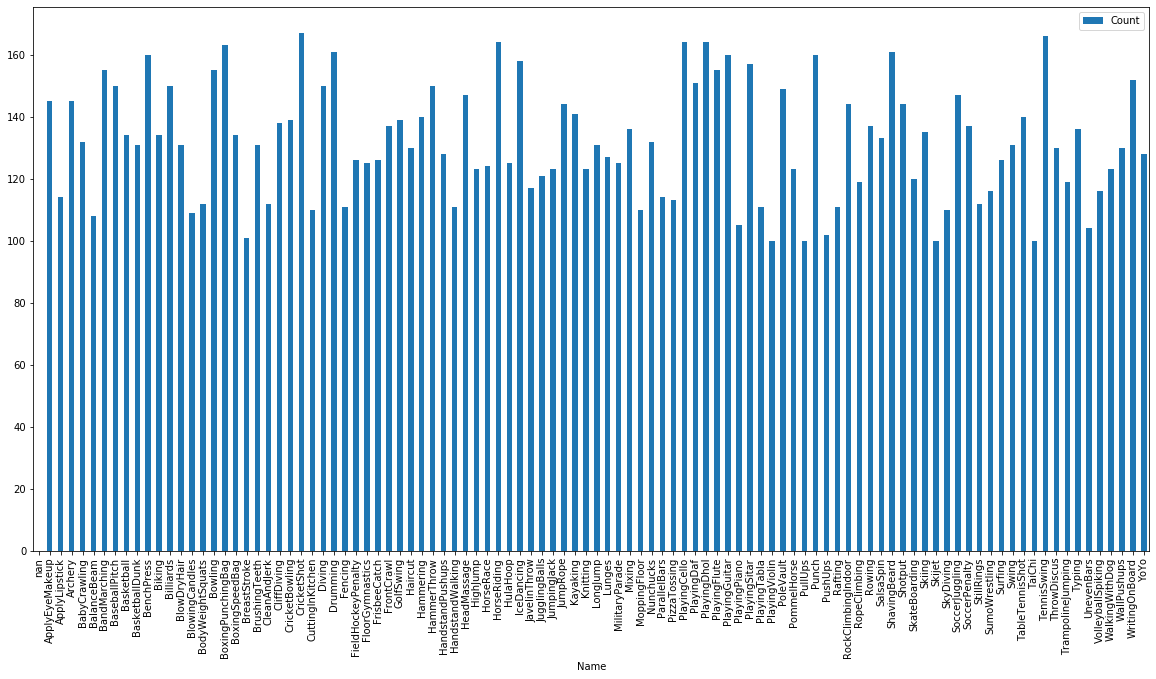

In [3]:
files = [f for f in glob.glob(BASE_PATH + '/' + FILE_SELECTOR, recursive=True)]
df = pd.DataFrame(columns=['Name', 'Count'], index=['Name'])
for f in files:
    directory = os.path.dirname(f).split(os.sep)[1]    
    index = df.index[df['Name'] == directory].tolist()
    if len(index) == 0:        
        df = df.append({'Name': directory, 'Count': 0}, ignore_index=True)

    df.loc[df['Name'] == directory, 'Count'] = df.loc[df['Name'] == directory, 'Count'] + 1

df.plot.bar(x='Name', y='Count', rot=90, figsize=(20,10))

# Step 2 - Prepare Data

### Train/Validation split

In [8]:
def read_classes(directory, selector='**/*.avi'):
    files = [f for f in glob.glob(directory + '/'+ selector, recursive=True)]
    df = pd.DataFrame(columns=['classes', 'classids', 'filepaths'])
    
    # Append all files
    for f in files:
        classname = os.path.dirname(f).split(os.sep)[1]    
        filepath = f.replace('\\', '/').replace(BASE_PATH, '')[1:]
        df = df.append({'classes': classname, 'classids': '', 'filepaths': filepath}, ignore_index=True)

    # Add class ids
    classes = df.classes.unique()
    for idx in range(len(classes)):
        classname = classes[idx]
        df.loc[(df['classes'] == classname),'classids'] = idx + 1   
    
    return df
    
df_classes = read_classes(BASE_PATH)

In [9]:
classes = df_classes.classes.unique()
print('Classes: {}'.format(len(classes)))
print(classes)

Classes: 101
['ApplyEyeMakeup' 'ApplyLipstick' 'Archery' 'BabyCrawling' 'BalanceBeam'
 'BandMarching' 'BaseballPitch' 'Basketball' 'BasketballDunk' 'BenchPress'
 'Biking' 'Billiards' 'BlowDryHair' 'BlowingCandles' 'BodyWeightSquats'
 'Bowling' 'BoxingPunchingBag' 'BoxingSpeedBag' 'BreastStroke'
 'BrushingTeeth' 'CleanAndJerk' 'CliffDiving' 'CricketBowling'
 'CricketShot' 'CuttingInKitchen' 'Diving' 'Drumming' 'Fencing'
 'FieldHockeyPenalty' 'FloorGymnastics' 'FrisbeeCatch' 'FrontCrawl'
 'GolfSwing' 'Haircut' 'Hammering' 'HammerThrow' 'HandstandPushups'
 'HandstandWalking' 'HeadMassage' 'HighJump' 'HorseRace' 'HorseRiding'
 'HulaHoop' 'IceDancing' 'JavelinThrow' 'JugglingBalls' 'JumpingJack'
 'JumpRope' 'Kayaking' 'Knitting' 'LongJump' 'Lunges' 'MilitaryParade'
 'Mixing' 'MoppingFloor' 'Nunchucks' 'ParallelBars' 'PizzaTossing'
 'PlayingCello' 'PlayingDaf' 'PlayingDhol' 'PlayingFlute' 'PlayingGuitar'
 'PlayingPiano' 'PlayingSitar' 'PlayingTabla' 'PlayingViolin' 'PoleVault'
 'PommelHorse'

In [10]:
trainfile = open('data/train.txt', 'w')
testfile = open('data/test.txt', 'w')

for idx in range(len(classes)):    
    class_subset = df_classes[df_classes['classes'] == classes[idx]]
    train, test = train_test_split(class_subset, test_size=0.2)    
    
    for index, row in train.iterrows():
        trainfile.write(row['filepaths'] + ' ' + str(row['classids']) + '\n')
        
    for index, row in test.iterrows():
        testfile.write(row['filepaths'] + '\n')        
    
trainfile.close()
testfile.close()

# Step 3 - Extract features from videos and cache them in files

### Sample 'SEQUENCE_LENGTH' frames from each video

In [11]:
def frame_generator():
    video_paths = tf.io.gfile.glob(VIDEOS_PATH)
    np.random.shuffle(video_paths)
    for video_path in video_paths:
        frames = []
        cap = cv2.VideoCapture(video_path)
        num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        sample_every_frame = max(1, num_frames // SEQUENCE_LENGTH)
        current_frame = 0

        label = os.path.basename(os.path.dirname(video_path))

        max_images = SEQUENCE_LENGTH
        while True:
            success, frame = cap.read()
            if not success:
                break

            if current_frame % sample_every_frame == 0:
                # OPENCV reads in BGR, tensorflow expects RGB so we invert the order
                frame = frame[:, :, ::-1]
                img = tf.image.resize(frame, (299, 299))
                img = tf.keras.applications.inception_v3.preprocess_input(
                    img)
                max_images -= 1
                yield img, video_path

            if max_images == 0:
                break
            current_frame += 1

dataset = tf.data.Dataset.from_generator(frame_generator,
             output_types=(tf.float32, tf.string),
             output_shapes=((299, 299, 3), ()))

dataset = dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

#### Extract Features from videos

In [12]:
inception_v3 = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
x = inception_v3.output

# We add Average Pooling to transform the feature map from
# 8 * 8 * 2048 to 1 x 2048, as we don't need spatial information
pooling_output = tf.keras.layers.GlobalAveragePooling2D()(x)
feature_extraction_model = tf.keras.Model(inception_v3.input, pooling_output)

28966912/87910968 [========>.....................] - ETA: 55:4 - ETA: 22:5 - ETA: 13:5 - ETA: 16:1 - ETA: 12:5 - ETA: 12:5 - ETA: 14:4 - ETA: 14:2 - ETA: 13:5 - ETA: 13:2 - ETA: 13:0 - ETA: 12:5 - ETA: 12:3 - ETA: 11:4 - ETA: 11:3 - ETA: 11:1 - ETA: 10:5 - ETA: 10:5 - ETA: 10:4 - ETA: 10:3 - ETA: 10:2 - ETA: 10:0 - ETA: 9:5 - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ET

87916544/87910968 [==============================] - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1:

In [13]:
current_path = None
all_features = []

for img, batch_paths in tqdm.tqdm(dataset):
    batch_features = feature_extraction_model(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1))
    
    for features, path in zip(batch_features.numpy(), batch_paths.numpy()):
        if path != current_path and current_path is not None:
            output_path = current_path.decode().replace('.avi', '.npy')
            np.save(output_path, all_features)
            all_features = []
            
        current_path = path
        all_features.append(features)

33295it [33:46:03,  3.65s/it]


# Step 2: Train the LSTM on video features

#### Labels preprocessing

In [14]:
LABELS = classes
encoder = LabelBinarizer()
encoder.fit(LABELS)
print('Classes: {}'.format(len(encoder.classes_)))

Classes: 101


#### Defining the model

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Masking(mask_value=0.),
    tf.keras.layers.LSTM(512, dropout=0.5, recurrent_dropout=0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(LABELS), activation='softmax')
])

In [16]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

In [17]:
test_file = os.path.join('data', 'test.txt')
train_file = os.path.join('data', 'train.txt')

with open('data/test.txt') as f:
    test_list = [row.strip() for row in list(f)]

with open('data/train.txt') as f:
    train_list = [row.strip() for row in list(f)]
    train_list = [row.split(' ')[0] for row in train_list]

def make_generator(file_list):
    def generator():
        np.random.shuffle(file_list)
        for path in file_list:
            full_path = os.path.join(BASE_PATH, path).replace('.avi', '.npy')

            label = os.path.basename(os.path.dirname(path))
            features = np.load(full_path)

            padded_sequence = np.zeros((SEQUENCE_LENGTH, 2048))
            padded_sequence[0:len(features)] = np.array(features)

            transformed_label = encoder.transform([label])
            yield padded_sequence, transformed_label[0]
    return generator

In [18]:
train_dataset = tf.data.Dataset.from_generator(make_generator(train_list),
                 output_types=(tf.float32, tf.int16),
                 output_shapes=((SEQUENCE_LENGTH, 2048), (len(LABELS))))
train_dataset = train_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)


valid_dataset = tf.data.Dataset.from_generator(make_generator(test_list),
                 output_types=(tf.float32, tf.int16),
                 output_shapes=((SEQUENCE_LENGTH, 2048), (len(LABELS))))
valid_dataset = valid_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

In [28]:
log_dir="logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(log_dir=log_dir, update_freq=1000, profile_batch=0)
checkpoint = ModelCheckpoint("model.h5", verbose=1, save_best_only=True)
earlystopping = EarlyStopping(patience=10, verbose=1)
model.fit(train_dataset, epochs=100, callbacks=[tensorboard_callback, checkpoint, earlystopping], validation_data=valid_dataset)

Epoch 1/100


     99/Unknown - 2s 2s/step - loss: 2.0830 - accuracy: 0.6875 - top_k_categorical_accuracy: 0.875 - 3s 2s/step - loss: 1.4908 - accuracy: 0.6875 - top_k_categorical_accuracy: 0.906 - 4s 1s/step - loss: 1.2137 - accuracy: 0.7083 - top_k_categorical_accuracy: 0.937 - 5s 1s/step - loss: 1.0812 - accuracy: 0.7500 - top_k_categorical_accuracy: 0.937 - 7s 1s/step - loss: 1.0658 - accuracy: 0.7250 - top_k_categorical_accuracy: 0.950 - 9s 1s/step - loss: 1.0324 - accuracy: 0.7396 - top_k_categorical_accuracy: 0.947 - 10s 1s/step - loss: 1.1351 - accuracy: 0.7054 - top_k_categorical_accuracy: 0.91 - 11s 1s/step - loss: 1.1453 - accuracy: 0.6875 - top_k_categorical_accuracy: 0.91 - 12s 1s/step - loss: 1.1178 - accuracy: 0.7083 - top_k_categorical_accuracy: 0.90 - 13s 1s/step - loss: 1.1030 - accuracy: 0.7063 - top_k_categorical_accuracy: 0.91 - 14s 1s/step - loss: 1.0892 - accuracy: 0.7045 - top_k_categorical_accuracy: 0.91 - 15s 1s/step - loss: 1.1277 - accuracy: 0.6927 - top_k_categorical_acc

    293/Unknown - 215s 1s/step - loss: 1.1598 - accuracy: 0.6583 - top_k_categorical_accuracy: 0.904 - 217s 1s/step - loss: 1.1578 - accuracy: 0.6585 - top_k_categorical_accuracy: 0.904 - 218s 1s/step - loss: 1.1543 - accuracy: 0.6595 - top_k_categorical_accuracy: 0.905 - 219s 1s/step - loss: 1.1516 - accuracy: 0.6603 - top_k_categorical_accuracy: 0.905 - 220s 1s/step - loss: 1.1557 - accuracy: 0.6598 - top_k_categorical_accuracy: 0.905 - 221s 1s/step - loss: 1.1577 - accuracy: 0.6590 - top_k_categorical_accuracy: 0.905 - 222s 1s/step - loss: 1.1649 - accuracy: 0.6586 - top_k_categorical_accuracy: 0.904 - 223s 1s/step - loss: 1.1664 - accuracy: 0.6584 - top_k_categorical_accuracy: 0.904 - 224s 1s/step - loss: 1.1652 - accuracy: 0.6585 - top_k_categorical_accuracy: 0.903 - 225s 1s/step - loss: 1.1650 - accuracy: 0.6584 - top_k_categorical_accuracy: 0.903 - 226s 1s/step - loss: 1.1661 - accuracy: 0.6585 - top_k_categorical_accuracy: 0.903 - 227s 1s/step - loss: 1.1668 - accuracy: 0.6581 

    390/Unknown - 321s 1s/step - loss: 1.1732 - accuracy: 0.6580 - top_k_categorical_accuracy: 0.900 - 322s 1s/step - loss: 1.1721 - accuracy: 0.6583 - top_k_categorical_accuracy: 0.900 - 323s 1s/step - loss: 1.1736 - accuracy: 0.6582 - top_k_categorical_accuracy: 0.900 - 324s 1s/step - loss: 1.1752 - accuracy: 0.6580 - top_k_categorical_accuracy: 0.900 - 325s 1s/step - loss: 1.1762 - accuracy: 0.6577 - top_k_categorical_accuracy: 0.900 - 326s 1s/step - loss: 1.1761 - accuracy: 0.6582 - top_k_categorical_accuracy: 0.900 - 327s 1s/step - loss: 1.1751 - accuracy: 0.6583 - top_k_categorical_accuracy: 0.900 - 328s 1s/step - loss: 1.1753 - accuracy: 0.6584 - top_k_categorical_accuracy: 0.901 - 329s 1s/step - loss: 1.1748 - accuracy: 0.6585 - top_k_categorical_accuracy: 0.901 - 331s 1s/step - loss: 1.1776 - accuracy: 0.6580 - top_k_categorical_accuracy: 0.901 - 332s 1s/step - loss: 1.1770 - accuracy: 0.6583 - top_k_categorical_accuracy: 0.901 - 333s 1s/step - loss: 1.1759 - accuracy: 0.6584 

    487/Unknown - 426s 1s/step - loss: 1.1617 - accuracy: 0.6629 - top_k_categorical_accuracy: 0.903 - 427s 1s/step - loss: 1.1610 - accuracy: 0.6631 - top_k_categorical_accuracy: 0.903 - 428s 1s/step - loss: 1.1598 - accuracy: 0.6633 - top_k_categorical_accuracy: 0.904 - 430s 1s/step - loss: 1.1603 - accuracy: 0.6634 - top_k_categorical_accuracy: 0.904 - 431s 1s/step - loss: 1.1605 - accuracy: 0.6633 - top_k_categorical_accuracy: 0.904 - 432s 1s/step - loss: 1.1603 - accuracy: 0.6635 - top_k_categorical_accuracy: 0.904 - 433s 1s/step - loss: 1.1617 - accuracy: 0.6634 - top_k_categorical_accuracy: 0.903 - 434s 1s/step - loss: 1.1610 - accuracy: 0.6638 - top_k_categorical_accuracy: 0.903 - 435s 1s/step - loss: 1.1617 - accuracy: 0.6635 - top_k_categorical_accuracy: 0.903 - 436s 1s/step - loss: 1.1622 - accuracy: 0.6633 - top_k_categorical_accuracy: 0.903 - 437s 1s/step - loss: 1.1627 - accuracy: 0.6633 - top_k_categorical_accuracy: 0.903 - 438s 1s/step - loss: 1.1639 - accuracy: 0.6632 

    584/Unknown - 517s 1s/step - loss: 1.1622 - accuracy: 0.6621 - top_k_categorical_accuracy: 0.903 - 518s 1s/step - loss: 1.1635 - accuracy: 0.6617 - top_k_categorical_accuracy: 0.903 - 519s 1s/step - loss: 1.1632 - accuracy: 0.6617 - top_k_categorical_accuracy: 0.904 - 520s 1s/step - loss: 1.1641 - accuracy: 0.6618 - top_k_categorical_accuracy: 0.903 - 521s 1s/step - loss: 1.1646 - accuracy: 0.6617 - top_k_categorical_accuracy: 0.903 - 522s 1s/step - loss: 1.1647 - accuracy: 0.6618 - top_k_categorical_accuracy: 0.903 - 523s 1s/step - loss: 1.1640 - accuracy: 0.6618 - top_k_categorical_accuracy: 0.904 - 524s 1s/step - loss: 1.1632 - accuracy: 0.6620 - top_k_categorical_accuracy: 0.904 - 525s 1s/step - loss: 1.1633 - accuracy: 0.6622 - top_k_categorical_accuracy: 0.904 - 526s 1s/step - loss: 1.1623 - accuracy: 0.6623 - top_k_categorical_accuracy: 0.904 - 526s 1s/step - loss: 1.1618 - accuracy: 0.6628 - top_k_categorical_accuracy: 0.904 - 527s 1s/step - loss: 1.1624 - accuracy: 0.6627 

    664/Unknown - 607s 1s/step - loss: 1.1492 - accuracy: 0.6675 - top_k_categorical_accuracy: 0.904 - 608s 1s/step - loss: 1.1497 - accuracy: 0.6678 - top_k_categorical_accuracy: 0.904 - 609s 1s/step - loss: 1.1496 - accuracy: 0.6679 - top_k_categorical_accuracy: 0.904 - 610s 1s/step - loss: 1.1496 - accuracy: 0.6677 - top_k_categorical_accuracy: 0.905 - 611s 1s/step - loss: 1.1487 - accuracy: 0.6679 - top_k_categorical_accuracy: 0.905 - 612s 1s/step - loss: 1.1477 - accuracy: 0.6681 - top_k_categorical_accuracy: 0.905 - 613s 1s/step - loss: 1.1476 - accuracy: 0.6684 - top_k_categorical_accuracy: 0.905 - 614s 1s/step - loss: 1.1471 - accuracy: 0.6684 - top_k_categorical_accuracy: 0.905 - 615s 1s/step - loss: 1.1483 - accuracy: 0.6682 - top_k_categorical_accuracy: 0.905 - 616s 1s/step - loss: 1.1486 - accuracy: 0.6681 - top_k_categorical_accuracy: 0.905 - 617s 1s/step - loss: 1.1498 - accuracy: 0.6680 - top_k_categorical_accuracy: 0.904 - 618s 1s/step - loss: 1.1506 - accuracy: 0.6678 

100/169 [================>.............] - ETA: 4:49 - loss: 0.8113 - accuracy: 0.8125 - top_k_categorical_accuracy: 0.937 - ETA: 4:29 - loss: 1.1161 - accuracy: 0.6875 - top_k_categorical_accuracy: 0.875 - ETA: 3:50 - loss: 1.2272 - accuracy: 0.6250 - top_k_categorical_accuracy: 0.875 - ETA: 3:44 - loss: 1.2113 - accuracy: 0.6250 - top_k_categorical_accuracy: 0.875 - ETA: 3:25 - loss: 1.2087 - accuracy: 0.6250 - top_k_categorical_accuracy: 0.875 - ETA: 3:13 - loss: 1.1247 - accuracy: 0.6667 - top_k_categorical_accuracy: 0.895 - ETA: 3:05 - loss: 1.1331 - accuracy: 0.6696 - top_k_categorical_accuracy: 0.883 - ETA: 2:58 - loss: 1.1052 - accuracy: 0.6797 - top_k_categorical_accuracy: 0.898 - ETA: 2:53 - loss: 1.1220 - accuracy: 0.6875 - top_k_categorical_accuracy: 0.895 - ETA: 2:49 - loss: 1.0834 - accuracy: 0.7000 - top_k_categorical_accuracy: 0.900 - ETA: 2:46 - loss: 1.0888 - accuracy: 0.6875 - top_k_categorical_accuracy: 0.903 - ETA: 2:42 - loss: 1.0917 - accuracy: 0.6823 - top_k_cat

100/169 [================>.............] - ETA: 3:50 - loss: 0.6190 - accuracy: 0.8125 - top_k_categorical_accuracy: 1.000 - ETA: 3:07 - loss: 0.7024 - accuracy: 0.7500 - top_k_categorical_accuracy: 1.000 - ETA: 2:54 - loss: 0.7261 - accuracy: 0.7500 - top_k_categorical_accuracy: 0.958 - ETA: 2:49 - loss: 0.7700 - accuracy: 0.7500 - top_k_categorical_accuracy: 0.953 - ETA: 2:46 - loss: 0.6802 - accuracy: 0.8000 - top_k_categorical_accuracy: 0.962 - ETA: 2:42 - loss: 0.7951 - accuracy: 0.7708 - top_k_categorical_accuracy: 0.947 - ETA: 2:39 - loss: 0.7440 - accuracy: 0.7768 - top_k_categorical_accuracy: 0.955 - ETA: 2:37 - loss: 0.6967 - accuracy: 0.7891 - top_k_categorical_accuracy: 0.960 - ETA: 2:36 - loss: 0.6872 - accuracy: 0.7986 - top_k_categorical_accuracy: 0.958 - ETA: 2:35 - loss: 0.7634 - accuracy: 0.7875 - top_k_categorical_accuracy: 0.956 - ETA: 2:33 - loss: 0.7664 - accuracy: 0.7784 - top_k_categorical_accuracy: 0.954 - ETA: 2:32 - loss: 0.7812 - accuracy: 0.7708 - top_k_cat

168/169 [============================>.] - ETA: 1:03 - loss: 1.0551 - accuracy: 0.7036 - top_k_categorical_accuracy: 0.920 - ETA: 1:03 - loss: 1.0539 - accuracy: 0.7040 - top_k_categorical_accuracy: 0.921 - ETA: 1:02 - loss: 1.0576 - accuracy: 0.7033 - top_k_categorical_accuracy: 0.920 - ETA: 1:01 - loss: 1.0501 - accuracy: 0.7055 - top_k_categorical_accuracy: 0.921 - ETA: 1:00 - loss: 1.0494 - accuracy: 0.7065 - top_k_categorical_accuracy: 0.920 - ETA: 59s - loss: 1.0453 - accuracy: 0.7081 - top_k_categorical_accuracy: 0.921 - ETA: 58s - loss: 1.0380 - accuracy: 0.7109 - top_k_categorical_accuracy: 0.92 - ETA: 57s - loss: 1.0369 - accuracy: 0.7106 - top_k_categorical_accuracy: 0.92 - ETA: 56s - loss: 1.0339 - accuracy: 0.7122 - top_k_categorical_accuracy: 0.92 - ETA: 55s - loss: 1.0314 - accuracy: 0.7108 - top_k_categorical_accuracy: 0.92 - ETA: 54s - loss: 1.0336 - accuracy: 0.7106 - top_k_categorical_accuracy: 0.92 - ETA: 53s - loss: 1.0346 - accuracy: 0.7104 - top_k_categorical_acc

100/169 [================>.............] - ETA: 3:27 - loss: 0.4026 - accuracy: 0.8125 - top_k_categorical_accuracy: 1.000 - ETA: 3:10 - loss: 0.7685 - accuracy: 0.8125 - top_k_categorical_accuracy: 0.968 - ETA: 3:02 - loss: 0.7887 - accuracy: 0.7500 - top_k_categorical_accuracy: 0.958 - ETA: 2:57 - loss: 0.8565 - accuracy: 0.7656 - top_k_categorical_accuracy: 0.937 - ETA: 2:53 - loss: 0.7775 - accuracy: 0.7500 - top_k_categorical_accuracy: 0.950 - ETA: 2:51 - loss: 0.8543 - accuracy: 0.7396 - top_k_categorical_accuracy: 0.958 - ETA: 2:49 - loss: 0.8596 - accuracy: 0.7321 - top_k_categorical_accuracy: 0.955 - ETA: 2:47 - loss: 0.9183 - accuracy: 0.7188 - top_k_categorical_accuracy: 0.945 - ETA: 2:45 - loss: 0.9215 - accuracy: 0.7083 - top_k_categorical_accuracy: 0.951 - ETA: 2:43 - loss: 0.9222 - accuracy: 0.7000 - top_k_categorical_accuracy: 0.950 - ETA: 2:42 - loss: 0.9630 - accuracy: 0.6875 - top_k_categorical_accuracy: 0.943 - ETA: 2:41 - loss: 0.9739 - accuracy: 0.6823 - top_k_cat

100/169 [================>.............] - ETA: 4:03 - loss: 1.2230 - accuracy: 0.6875 - top_k_categorical_accuracy: 0.937 - ETA: 3:32 - loss: 0.7042 - accuracy: 0.8438 - top_k_categorical_accuracy: 0.968 - ETA: 3:21 - loss: 0.7140 - accuracy: 0.8125 - top_k_categorical_accuracy: 0.958 - ETA: 3:13 - loss: 0.7673 - accuracy: 0.7500 - top_k_categorical_accuracy: 0.968 - ETA: 3:08 - loss: 0.6884 - accuracy: 0.7750 - top_k_categorical_accuracy: 0.975 - ETA: 3:03 - loss: 0.7272 - accuracy: 0.7812 - top_k_categorical_accuracy: 0.968 - ETA: 2:58 - loss: 0.6699 - accuracy: 0.7946 - top_k_categorical_accuracy: 0.973 - ETA: 2:54 - loss: 0.6260 - accuracy: 0.7969 - top_k_categorical_accuracy: 0.976 - ETA: 2:51 - loss: 0.5839 - accuracy: 0.8056 - top_k_categorical_accuracy: 0.979 - ETA: 2:49 - loss: 0.6191 - accuracy: 0.8000 - top_k_categorical_accuracy: 0.975 - ETA: 2:46 - loss: 0.6123 - accuracy: 0.8125 - top_k_categorical_accuracy: 0.977 - ETA: 2:43 - loss: 0.7442 - accuracy: 0.7760 - top_k_cat

168/169 [============================>.] - ETA: 1:08 - loss: 0.7984 - accuracy: 0.7624 - top_k_categorical_accuracy: 0.954 - ETA: 1:07 - loss: 0.7965 - accuracy: 0.7629 - top_k_categorical_accuracy: 0.954 - ETA: 1:06 - loss: 0.8000 - accuracy: 0.7633 - top_k_categorical_accuracy: 0.953 - ETA: 1:05 - loss: 0.7968 - accuracy: 0.7638 - top_k_categorical_accuracy: 0.953 - ETA: 1:04 - loss: 0.7915 - accuracy: 0.7643 - top_k_categorical_accuracy: 0.954 - ETA: 1:03 - loss: 0.7896 - accuracy: 0.7653 - top_k_categorical_accuracy: 0.954 - ETA: 1:02 - loss: 0.7890 - accuracy: 0.7664 - top_k_categorical_accuracy: 0.954 - ETA: 1:01 - loss: 0.7894 - accuracy: 0.7662 - top_k_categorical_accuracy: 0.954 - ETA: 1:00 - loss: 0.7952 - accuracy: 0.7649 - top_k_categorical_accuracy: 0.953 - ETA: 59s - loss: 0.7919 - accuracy: 0.7653 - top_k_categorical_accuracy: 0.954 - ETA: 58s - loss: 0.7931 - accuracy: 0.7658 - top_k_categorical_accuracy: 0.95 - ETA: 57s - loss: 0.7964 - accuracy: 0.7645 - top_k_categor

100/169 [================>.............] - ETA: 4:13 - loss: 1.0414 - accuracy: 0.7500 - top_k_categorical_accuracy: 0.937 - ETA: 3:31 - loss: 0.8919 - accuracy: 0.8125 - top_k_categorical_accuracy: 0.937 - ETA: 3:14 - loss: 0.9518 - accuracy: 0.7708 - top_k_categorical_accuracy: 0.895 - ETA: 3:07 - loss: 0.9328 - accuracy: 0.7656 - top_k_categorical_accuracy: 0.921 - ETA: 3:00 - loss: 0.9076 - accuracy: 0.7625 - top_k_categorical_accuracy: 0.937 - ETA: 2:56 - loss: 0.7717 - accuracy: 0.8021 - top_k_categorical_accuracy: 0.947 - ETA: 2:54 - loss: 0.7780 - accuracy: 0.7768 - top_k_categorical_accuracy: 0.946 - ETA: 2:53 - loss: 0.8215 - accuracy: 0.7734 - top_k_categorical_accuracy: 0.945 - ETA: 2:49 - loss: 0.7947 - accuracy: 0.7708 - top_k_categorical_accuracy: 0.951 - ETA: 2:48 - loss: 0.8025 - accuracy: 0.7688 - top_k_categorical_accuracy: 0.950 - ETA: 2:47 - loss: 0.8052 - accuracy: 0.7670 - top_k_categorical_accuracy: 0.954 - ETA: 2:46 - loss: 0.8412 - accuracy: 0.7604 - top_k_cat

100/169 [================>.............] - ETA: 3:55 - loss: 0.9782 - accuracy: 0.6875 - top_k_categorical_accuracy: 0.937 - ETA: 3:24 - loss: 0.8914 - accuracy: 0.7188 - top_k_categorical_accuracy: 0.906 - ETA: 3:12 - loss: 0.8308 - accuracy: 0.7500 - top_k_categorical_accuracy: 0.916 - ETA: 3:08 - loss: 0.8241 - accuracy: 0.7812 - top_k_categorical_accuracy: 0.937 - ETA: 3:01 - loss: 0.7248 - accuracy: 0.8000 - top_k_categorical_accuracy: 0.950 - ETA: 2:57 - loss: 0.7607 - accuracy: 0.7812 - top_k_categorical_accuracy: 0.958 - ETA: 2:56 - loss: 0.6835 - accuracy: 0.8036 - top_k_categorical_accuracy: 0.964 - ETA: 2:54 - loss: 0.7058 - accuracy: 0.7891 - top_k_categorical_accuracy: 0.968 - ETA: 2:53 - loss: 0.7706 - accuracy: 0.7917 - top_k_categorical_accuracy: 0.965 - ETA: 2:51 - loss: 0.7494 - accuracy: 0.7937 - top_k_categorical_accuracy: 0.968 - ETA: 2:50 - loss: 0.7533 - accuracy: 0.7955 - top_k_categorical_accuracy: 0.971 - ETA: 2:48 - loss: 0.7704 - accuracy: 0.7917 - top_k_cat

168/169 [============================>.] - ETA: 1:13 - loss: 0.7144 - accuracy: 0.8020 - top_k_categorical_accuracy: 0.958 - ETA: 1:12 - loss: 0.7147 - accuracy: 0.8021 - top_k_categorical_accuracy: 0.958 - ETA: 1:11 - loss: 0.7096 - accuracy: 0.8040 - top_k_categorical_accuracy: 0.958 - ETA: 1:09 - loss: 0.7150 - accuracy: 0.8017 - top_k_categorical_accuracy: 0.957 - ETA: 1:08 - loss: 0.7165 - accuracy: 0.8000 - top_k_categorical_accuracy: 0.958 - ETA: 1:07 - loss: 0.7212 - accuracy: 0.7989 - top_k_categorical_accuracy: 0.957 - ETA: 1:06 - loss: 0.7168 - accuracy: 0.8002 - top_k_categorical_accuracy: 0.957 - ETA: 1:05 - loss: 0.7160 - accuracy: 0.7992 - top_k_categorical_accuracy: 0.958 - ETA: 1:04 - loss: 0.7141 - accuracy: 0.7999 - top_k_categorical_accuracy: 0.958 - ETA: 1:03 - loss: 0.7112 - accuracy: 0.8000 - top_k_categorical_accuracy: 0.959 - ETA: 1:02 - loss: 0.7084 - accuracy: 0.8007 - top_k_categorical_accuracy: 0.959 - ETA: 1:01 - loss: 0.7047 - accuracy: 0.8013 - top_k_cat

100/169 [================>.............] - ETA: 3:58 - loss: 1.0538 - accuracy: 0.6875 - top_k_categorical_accuracy: 0.937 - ETA: 3:26 - loss: 0.9385 - accuracy: 0.6875 - top_k_categorical_accuracy: 0.937 - ETA: 3:19 - loss: 1.0743 - accuracy: 0.6667 - top_k_categorical_accuracy: 0.916 - ETA: 3:12 - loss: 0.9996 - accuracy: 0.6875 - top_k_categorical_accuracy: 0.921 - ETA: 3:07 - loss: 0.8863 - accuracy: 0.7250 - top_k_categorical_accuracy: 0.937 - ETA: 3:08 - loss: 0.8583 - accuracy: 0.7292 - top_k_categorical_accuracy: 0.937 - ETA: 3:03 - loss: 0.8754 - accuracy: 0.7321 - top_k_categorical_accuracy: 0.928 - ETA: 2:59 - loss: 0.8252 - accuracy: 0.7500 - top_k_categorical_accuracy: 0.929 - ETA: 2:58 - loss: 0.7853 - accuracy: 0.7639 - top_k_categorical_accuracy: 0.937 - ETA: 2:56 - loss: 0.7867 - accuracy: 0.7563 - top_k_categorical_accuracy: 0.943 - ETA: 2:54 - loss: 0.8000 - accuracy: 0.7500 - top_k_categorical_accuracy: 0.937 - ETA: 2:52 - loss: 0.8574 - accuracy: 0.7448 - top_k_cat

100/169 [================>.............] - ETA: 4:03 - loss: 0.7522 - accuracy: 0.6875 - top_k_categorical_accuracy: 0.937 - ETA: 3:29 - loss: 0.4034 - accuracy: 0.8438 - top_k_categorical_accuracy: 0.968 - ETA: 3:19 - loss: 0.5557 - accuracy: 0.7917 - top_k_categorical_accuracy: 0.958 - ETA: 3:16 - loss: 0.4820 - accuracy: 0.8281 - top_k_categorical_accuracy: 0.968 - ETA: 3:09 - loss: 0.4875 - accuracy: 0.8375 - top_k_categorical_accuracy: 0.962 - ETA: 3:05 - loss: 0.6377 - accuracy: 0.8021 - top_k_categorical_accuracy: 0.947 - ETA: 3:03 - loss: 0.6345 - accuracy: 0.8125 - top_k_categorical_accuracy: 0.955 - ETA: 3:02 - loss: 0.7267 - accuracy: 0.8203 - top_k_categorical_accuracy: 0.945 - ETA: 3:01 - loss: 0.7169 - accuracy: 0.8194 - top_k_categorical_accuracy: 0.944 - ETA: 2:59 - loss: 0.7599 - accuracy: 0.8188 - top_k_categorical_accuracy: 0.950 - ETA: 2:59 - loss: 0.8000 - accuracy: 0.8125 - top_k_categorical_accuracy: 0.948 - ETA: 2:58 - loss: 0.7949 - accuracy: 0.8125 - top_k_cat

168/169 [============================>.] - ETA: 1:15 - loss: 0.7038 - accuracy: 0.8100 - top_k_categorical_accuracy: 0.953 - ETA: 1:14 - loss: 0.7192 - accuracy: 0.8088 - top_k_categorical_accuracy: 0.952 - ETA: 1:13 - loss: 0.7227 - accuracy: 0.8076 - top_k_categorical_accuracy: 0.952 - ETA: 1:12 - loss: 0.7233 - accuracy: 0.8065 - top_k_categorical_accuracy: 0.951 - ETA: 1:11 - loss: 0.7252 - accuracy: 0.8060 - top_k_categorical_accuracy: 0.951 - ETA: 1:10 - loss: 0.7221 - accuracy: 0.8060 - top_k_categorical_accuracy: 0.952 - ETA: 1:08 - loss: 0.7295 - accuracy: 0.8037 - top_k_categorical_accuracy: 0.952 - ETA: 1:07 - loss: 0.7372 - accuracy: 0.8027 - top_k_categorical_accuracy: 0.950 - ETA: 1:06 - loss: 0.7353 - accuracy: 0.8028 - top_k_categorical_accuracy: 0.950 - ETA: 1:05 - loss: 0.7328 - accuracy: 0.8034 - top_k_categorical_accuracy: 0.951 - ETA: 1:04 - loss: 0.7334 - accuracy: 0.8035 - top_k_categorical_accuracy: 0.951 - ETA: 1:03 - loss: 0.7285 - accuracy: 0.8041 - top_k_cat

100/169 [================>.............] - ETA: 5:01 - loss: 0.8097 - accuracy: 0.7500 - top_k_categorical_accuracy: 0.937 - ETA: 4:22 - loss: 0.8270 - accuracy: 0.7500 - top_k_categorical_accuracy: 0.968 - ETA: 4:10 - loss: 0.8770 - accuracy: 0.7292 - top_k_categorical_accuracy: 0.958 - ETA: 4:03 - loss: 0.9147 - accuracy: 0.7188 - top_k_categorical_accuracy: 0.953 - ETA: 4:10 - loss: 0.8392 - accuracy: 0.7375 - top_k_categorical_accuracy: 0.962 - ETA: 4:08 - loss: 0.7827 - accuracy: 0.7604 - top_k_categorical_accuracy: 0.968 - ETA: 4:03 - loss: 0.7452 - accuracy: 0.7679 - top_k_categorical_accuracy: 0.973 - ETA: 3:58 - loss: 0.7504 - accuracy: 0.7656 - top_k_categorical_accuracy: 0.960 - ETA: 3:57 - loss: 0.7339 - accuracy: 0.7708 - top_k_categorical_accuracy: 0.958 - ETA: 3:53 - loss: 0.7195 - accuracy: 0.7688 - top_k_categorical_accuracy: 0.956 - ETA: 3:53 - loss: 0.6771 - accuracy: 0.7841 - top_k_categorical_accuracy: 0.960 - ETA: 3:48 - loss: 0.6887 - accuracy: 0.7812 - top_k_cat

100/169 [================>.............] - ETA: 4:39 - loss: 0.6791 - accuracy: 0.6875 - top_k_categorical_accuracy: 0.937 - ETA: 3:54 - loss: 0.3717 - accuracy: 0.8438 - top_k_categorical_accuracy: 0.968 - ETA: 3:38 - loss: 0.3729 - accuracy: 0.8542 - top_k_categorical_accuracy: 0.979 - ETA: 3:30 - loss: 0.3790 - accuracy: 0.8594 - top_k_categorical_accuracy: 0.984 - ETA: 3:24 - loss: 0.3419 - accuracy: 0.8750 - top_k_categorical_accuracy: 0.987 - ETA: 3:19 - loss: 0.3489 - accuracy: 0.8854 - top_k_categorical_accuracy: 0.989 - ETA: 3:21 - loss: 0.5191 - accuracy: 0.8661 - top_k_categorical_accuracy: 0.982 - ETA: 3:45 - loss: 0.4950 - accuracy: 0.8672 - top_k_categorical_accuracy: 0.984 - ETA: 3:41 - loss: 0.4841 - accuracy: 0.8750 - top_k_categorical_accuracy: 0.986 - ETA: 3:37 - loss: 0.4524 - accuracy: 0.8875 - top_k_categorical_accuracy: 0.987 - ETA: 3:33 - loss: 0.5452 - accuracy: 0.8750 - top_k_categorical_accuracy: 0.988 - ETA: 3:30 - loss: 0.5682 - accuracy: 0.8698 - top_k_cat

168/169 [============================>.] - ETA: 1:21 - loss: 0.7464 - accuracy: 0.7921 - top_k_categorical_accuracy: 0.962 - ETA: 1:20 - loss: 0.7413 - accuracy: 0.7929 - top_k_categorical_accuracy: 0.962 - ETA: 1:19 - loss: 0.7402 - accuracy: 0.7937 - top_k_categorical_accuracy: 0.962 - ETA: 1:18 - loss: 0.7397 - accuracy: 0.7933 - top_k_categorical_accuracy: 0.961 - ETA: 1:16 - loss: 0.7407 - accuracy: 0.7935 - top_k_categorical_accuracy: 0.961 - ETA: 1:15 - loss: 0.7414 - accuracy: 0.7925 - top_k_categorical_accuracy: 0.961 - ETA: 1:14 - loss: 0.7403 - accuracy: 0.7932 - top_k_categorical_accuracy: 0.961 - ETA: 1:13 - loss: 0.7420 - accuracy: 0.7928 - top_k_categorical_accuracy: 0.960 - ETA: 1:12 - loss: 0.7385 - accuracy: 0.7930 - top_k_categorical_accuracy: 0.961 - ETA: 1:10 - loss: 0.7355 - accuracy: 0.7932 - top_k_categorical_accuracy: 0.961 - ETA: 1:09 - loss: 0.7400 - accuracy: 0.7928 - top_k_categorical_accuracy: 0.961 - ETA: 1:08 - loss: 0.7403 - accuracy: 0.7930 - top_k_cat

100/169 [================>.............] - ETA: 4:53 - loss: 0.4972 - accuracy: 0.7500 - top_k_categorical_accuracy: 1.000 - ETA: 4:12 - loss: 0.5457 - accuracy: 0.7500 - top_k_categorical_accuracy: 1.000 - ETA: 3:57 - loss: 0.6091 - accuracy: 0.7500 - top_k_categorical_accuracy: 1.000 - ETA: 3:48 - loss: 0.7462 - accuracy: 0.7500 - top_k_categorical_accuracy: 0.968 - ETA: 3:41 - loss: 0.6886 - accuracy: 0.7750 - top_k_categorical_accuracy: 0.975 - ETA: 3:37 - loss: 0.7228 - accuracy: 0.7812 - top_k_categorical_accuracy: 0.979 - ETA: 3:31 - loss: 0.6972 - accuracy: 0.7768 - top_k_categorical_accuracy: 0.982 - ETA: 3:26 - loss: 0.6836 - accuracy: 0.7891 - top_k_categorical_accuracy: 0.984 - ETA: 3:23 - loss: 0.6733 - accuracy: 0.8056 - top_k_categorical_accuracy: 0.986 - ETA: 3:20 - loss: 0.6352 - accuracy: 0.8188 - top_k_categorical_accuracy: 0.987 - ETA: 3:24 - loss: 0.6130 - accuracy: 0.8295 - top_k_categorical_accuracy: 0.988 - ETA: 3:23 - loss: 0.6317 - accuracy: 0.8281 - top_k_cat

100/169 [================>.............] - ETA: 5:21 - loss: 0.8800 - accuracy: 0.6875 - top_k_categorical_accuracy: 1.000 - ETA: 4:17 - loss: 1.0670 - accuracy: 0.7500 - top_k_categorical_accuracy: 0.937 - ETA: 3:59 - loss: 0.8766 - accuracy: 0.7708 - top_k_categorical_accuracy: 0.958 - ETA: 3:54 - loss: 0.7167 - accuracy: 0.7969 - top_k_categorical_accuracy: 0.968 - ETA: 3:47 - loss: 0.6574 - accuracy: 0.8250 - top_k_categorical_accuracy: 0.962 - ETA: 3:42 - loss: 0.6199 - accuracy: 0.8229 - top_k_categorical_accuracy: 0.968 - ETA: 3:37 - loss: 0.6660 - accuracy: 0.8125 - top_k_categorical_accuracy: 0.973 - ETA: 3:37 - loss: 0.6463 - accuracy: 0.8047 - top_k_categorical_accuracy: 0.976 - ETA: 3:35 - loss: 0.6505 - accuracy: 0.7986 - top_k_categorical_accuracy: 0.972 - ETA: 3:34 - loss: 0.6294 - accuracy: 0.8000 - top_k_categorical_accuracy: 0.968 - ETA: 3:29 - loss: 0.6459 - accuracy: 0.8011 - top_k_categorical_accuracy: 0.965 - ETA: 3:26 - loss: 0.6684 - accuracy: 0.8021 - top_k_cat

168/169 [============================>.] - ETA: 1:25 - loss: 0.6287 - accuracy: 0.8150 - top_k_categorical_accuracy: 0.969 - ETA: 1:24 - loss: 0.6295 - accuracy: 0.8143 - top_k_categorical_accuracy: 0.969 - ETA: 1:23 - loss: 0.6292 - accuracy: 0.8149 - top_k_categorical_accuracy: 0.969 - ETA: 1:21 - loss: 0.6334 - accuracy: 0.8137 - top_k_categorical_accuracy: 0.969 - ETA: 1:20 - loss: 0.6356 - accuracy: 0.8137 - top_k_categorical_accuracy: 0.969 - ETA: 1:19 - loss: 0.6338 - accuracy: 0.8143 - top_k_categorical_accuracy: 0.969 - ETA: 1:18 - loss: 0.6367 - accuracy: 0.8131 - top_k_categorical_accuracy: 0.968 - ETA: 1:16 - loss: 0.6336 - accuracy: 0.8137 - top_k_categorical_accuracy: 0.968 - ETA: 1:15 - loss: 0.6312 - accuracy: 0.8142 - top_k_categorical_accuracy: 0.968 - ETA: 1:14 - loss: 0.6274 - accuracy: 0.8153 - top_k_categorical_accuracy: 0.968 - ETA: 1:13 - loss: 0.6249 - accuracy: 0.8164 - top_k_categorical_accuracy: 0.969 - ETA: 1:11 - loss: 0.6349 - accuracy: 0.8142 - top_k_cat

100/169 [================>.............] - ETA: 5:31 - loss: 0.4832 - accuracy: 0.8750 - top_k_categorical_accuracy: 1.000 - ETA: 4:28 - loss: 0.6050 - accuracy: 0.7812 - top_k_categorical_accuracy: 1.000 - ETA: 4:06 - loss: 0.4529 - accuracy: 0.8333 - top_k_categorical_accuracy: 1.000 - ETA: 3:57 - loss: 0.7518 - accuracy: 0.8125 - top_k_categorical_accuracy: 0.968 - ETA: 3:48 - loss: 0.6740 - accuracy: 0.8125 - top_k_categorical_accuracy: 0.975 - ETA: 3:43 - loss: 0.5868 - accuracy: 0.8333 - top_k_categorical_accuracy: 0.979 - ETA: 3:51 - loss: 0.6273 - accuracy: 0.8304 - top_k_categorical_accuracy: 0.973 - ETA: 3:45 - loss: 0.6211 - accuracy: 0.8359 - top_k_categorical_accuracy: 0.968 - ETA: 3:38 - loss: 0.5763 - accuracy: 0.8403 - top_k_categorical_accuracy: 0.972 - ETA: 3:36 - loss: 0.6361 - accuracy: 0.8188 - top_k_categorical_accuracy: 0.962 - ETA: 3:34 - loss: 0.6059 - accuracy: 0.8239 - top_k_categorical_accuracy: 0.965 - ETA: 3:32 - loss: 0.5923 - accuracy: 0.8281 - top_k_cat

100/169 [================>.............] - ETA: 5:55 - loss: 0.2003 - accuracy: 0.9375 - top_k_categorical_accuracy: 1.000 - ETA: 4:59 - loss: 0.1263 - accuracy: 0.9688 - top_k_categorical_accuracy: 1.000 - ETA: 4:40 - loss: 0.5337 - accuracy: 0.8750 - top_k_categorical_accuracy: 0.979 - ETA: 4:29 - loss: 0.6006 - accuracy: 0.8438 - top_k_categorical_accuracy: 0.968 - ETA: 4:27 - loss: 0.5758 - accuracy: 0.8500 - top_k_categorical_accuracy: 0.975 - ETA: 4:24 - loss: 0.6108 - accuracy: 0.8229 - top_k_categorical_accuracy: 0.979 - ETA: 4:20 - loss: 0.5844 - accuracy: 0.8304 - top_k_categorical_accuracy: 0.973 - ETA: 4:16 - loss: 0.5816 - accuracy: 0.8359 - top_k_categorical_accuracy: 0.976 - ETA: 4:13 - loss: 0.6164 - accuracy: 0.8264 - top_k_categorical_accuracy: 0.979 - ETA: 4:10 - loss: 0.5626 - accuracy: 0.8375 - top_k_categorical_accuracy: 0.981 - ETA: 4:06 - loss: 0.6095 - accuracy: 0.8239 - top_k_categorical_accuracy: 0.971 - ETA: 4:02 - loss: 0.6061 - accuracy: 0.8229 - top_k_cat

168/169 [============================>.] - ETA: 1:43 - loss: 0.6721 - accuracy: 0.8119 - top_k_categorical_accuracy: 0.967 - ETA: 1:42 - loss: 0.6751 - accuracy: 0.8113 - top_k_categorical_accuracy: 0.968 - ETA: 1:40 - loss: 0.6741 - accuracy: 0.8125 - top_k_categorical_accuracy: 0.968 - ETA: 1:39 - loss: 0.6709 - accuracy: 0.8137 - top_k_categorical_accuracy: 0.968 - ETA: 1:37 - loss: 0.6786 - accuracy: 0.8125 - top_k_categorical_accuracy: 0.968 - ETA: 1:36 - loss: 0.6806 - accuracy: 0.8119 - top_k_categorical_accuracy: 0.967 - ETA: 1:34 - loss: 0.6844 - accuracy: 0.8102 - top_k_categorical_accuracy: 0.967 - ETA: 1:32 - loss: 0.6858 - accuracy: 0.8108 - top_k_categorical_accuracy: 0.967 - ETA: 1:31 - loss: 0.6933 - accuracy: 0.8091 - top_k_categorical_accuracy: 0.966 - ETA: 1:29 - loss: 0.6938 - accuracy: 0.8091 - top_k_categorical_accuracy: 0.965 - ETA: 1:28 - loss: 0.6939 - accuracy: 0.8091 - top_k_categorical_accuracy: 0.966 - ETA: 1:26 - loss: 0.6950 - accuracy: 0.8086 - top_k_cat

100/169 [================>.............] - ETA: 5:14 - loss: 1.5987 - accuracy: 0.6250 - top_k_categorical_accuracy: 0.937 - ETA: 4:15 - loss: 1.1565 - accuracy: 0.7188 - top_k_categorical_accuracy: 0.968 - ETA: 3:56 - loss: 1.0026 - accuracy: 0.7500 - top_k_categorical_accuracy: 0.958 - ETA: 3:48 - loss: 0.9608 - accuracy: 0.7969 - top_k_categorical_accuracy: 0.968 - ETA: 3:43 - loss: 0.8905 - accuracy: 0.8000 - top_k_categorical_accuracy: 0.962 - ETA: 3:38 - loss: 0.8056 - accuracy: 0.8021 - top_k_categorical_accuracy: 0.968 - ETA: 3:32 - loss: 0.7457 - accuracy: 0.8125 - top_k_categorical_accuracy: 0.973 - ETA: 3:28 - loss: 0.8203 - accuracy: 0.7969 - top_k_categorical_accuracy: 0.976 - ETA: 3:26 - loss: 0.8270 - accuracy: 0.7986 - top_k_categorical_accuracy: 0.979 - ETA: 3:26 - loss: 0.9577 - accuracy: 0.7812 - top_k_categorical_accuracy: 0.968 - ETA: 3:23 - loss: 0.9248 - accuracy: 0.7898 - top_k_categorical_accuracy: 0.971 - ETA: 3:20 - loss: 0.9599 - accuracy: 0.7760 - top_k_cat

100/169 [================>.............] - ETA: 4:39 - loss: 1.1342 - accuracy: 0.6875 - top_k_categorical_accuracy: 0.875 - ETA: 3:55 - loss: 0.9998 - accuracy: 0.7500 - top_k_categorical_accuracy: 0.875 - ETA: 3:51 - loss: 0.9050 - accuracy: 0.7917 - top_k_categorical_accuracy: 0.875 - ETA: 3:46 - loss: 0.7512 - accuracy: 0.8281 - top_k_categorical_accuracy: 0.906 - ETA: 3:41 - loss: 0.7056 - accuracy: 0.8375 - top_k_categorical_accuracy: 0.925 - ETA: 3:37 - loss: 0.7699 - accuracy: 0.8125 - top_k_categorical_accuracy: 0.927 - ETA: 3:34 - loss: 0.6892 - accuracy: 0.8304 - top_k_categorical_accuracy: 0.937 - ETA: 3:32 - loss: 0.7350 - accuracy: 0.8281 - top_k_categorical_accuracy: 0.937 - ETA: 3:30 - loss: 0.7473 - accuracy: 0.7986 - top_k_categorical_accuracy: 0.937 - ETA: 3:29 - loss: 0.8209 - accuracy: 0.7875 - top_k_categorical_accuracy: 0.937 - ETA: 3:27 - loss: 0.8034 - accuracy: 0.7955 - top_k_categorical_accuracy: 0.937 - ETA: 3:25 - loss: 0.8247 - accuracy: 0.7969 - top_k_cat

168/169 [============================>.] - ETA: 1:28 - loss: 0.6844 - accuracy: 0.8274 - top_k_categorical_accuracy: 0.966 - ETA: 1:27 - loss: 0.6802 - accuracy: 0.8278 - top_k_categorical_accuracy: 0.966 - ETA: 1:26 - loss: 0.6806 - accuracy: 0.8283 - top_k_categorical_accuracy: 0.966 - ETA: 1:24 - loss: 0.6822 - accuracy: 0.8281 - top_k_categorical_accuracy: 0.966 - ETA: 1:23 - loss: 0.6809 - accuracy: 0.8286 - top_k_categorical_accuracy: 0.966 - ETA: 1:22 - loss: 0.6812 - accuracy: 0.8284 - top_k_categorical_accuracy: 0.967 - ETA: 1:20 - loss: 0.6782 - accuracy: 0.8294 - top_k_categorical_accuracy: 0.967 - ETA: 1:19 - loss: 0.6736 - accuracy: 0.8304 - top_k_categorical_accuracy: 0.967 - ETA: 1:18 - loss: 0.6759 - accuracy: 0.8303 - top_k_categorical_accuracy: 0.966 - ETA: 1:16 - loss: 0.6747 - accuracy: 0.8307 - top_k_categorical_accuracy: 0.966 - ETA: 1:15 - loss: 0.6748 - accuracy: 0.8311 - top_k_categorical_accuracy: 0.966 - ETA: 1:14 - loss: 0.6748 - accuracy: 0.8315 - top_k_cat

100/169 [================>.............] - ETA: 5:21 - loss: 0.9537 - accuracy: 0.8125 - top_k_categorical_accuracy: 0.937 - ETA: 4:32 - loss: 0.7866 - accuracy: 0.8125 - top_k_categorical_accuracy: 0.968 - ETA: 4:16 - loss: 0.8280 - accuracy: 0.7917 - top_k_categorical_accuracy: 0.958 - ETA: 4:05 - loss: 0.9101 - accuracy: 0.8125 - top_k_categorical_accuracy: 0.953 - ETA: 4:05 - loss: 0.9043 - accuracy: 0.8125 - top_k_categorical_accuracy: 0.937 - ETA: 3:59 - loss: 0.9015 - accuracy: 0.8229 - top_k_categorical_accuracy: 0.937 - ETA: 3:57 - loss: 0.8688 - accuracy: 0.8125 - top_k_categorical_accuracy: 0.946 - ETA: 3:55 - loss: 0.8654 - accuracy: 0.7969 - top_k_categorical_accuracy: 0.953 - ETA: 3:52 - loss: 0.8256 - accuracy: 0.8056 - top_k_categorical_accuracy: 0.958 - ETA: 3:57 - loss: 0.8550 - accuracy: 0.7875 - top_k_categorical_accuracy: 0.962 - ETA: 3:52 - loss: 0.8489 - accuracy: 0.7898 - top_k_categorical_accuracy: 0.960 - ETA: 3:50 - loss: 0.8026 - accuracy: 0.8021 - top_k_cat

100/169 [================>.............] - ETA: 5:58 - loss: 0.2631 - accuracy: 0.8750 - top_k_categorical_accuracy: 1.000 - ETA: 4:43 - loss: 0.7757 - accuracy: 0.8125 - top_k_categorical_accuracy: 0.906 - ETA: 4:24 - loss: 0.6096 - accuracy: 0.8542 - top_k_categorical_accuracy: 0.937 - ETA: 4:15 - loss: 0.7444 - accuracy: 0.8125 - top_k_categorical_accuracy: 0.937 - ETA: 4:08 - loss: 0.7467 - accuracy: 0.7875 - top_k_categorical_accuracy: 0.950 - ETA: 3:59 - loss: 0.6632 - accuracy: 0.8125 - top_k_categorical_accuracy: 0.958 - ETA: 3:57 - loss: 0.6713 - accuracy: 0.8036 - top_k_categorical_accuracy: 0.955 - ETA: 3:56 - loss: 0.5897 - accuracy: 0.8281 - top_k_categorical_accuracy: 0.960 - ETA: 3:50 - loss: 0.5858 - accuracy: 0.8264 - top_k_categorical_accuracy: 0.965 - ETA: 3:47 - loss: 0.5967 - accuracy: 0.8250 - top_k_categorical_accuracy: 0.968 - ETA: 3:44 - loss: 0.6383 - accuracy: 0.8239 - top_k_categorical_accuracy: 0.960 - ETA: 3:41 - loss: 0.7039 - accuracy: 0.8073 - top_k_cat

168/169 [============================>.] - ETA: 1:34 - loss: 0.7136 - accuracy: 0.7983 - top_k_categorical_accuracy: 0.961 - ETA: 1:32 - loss: 0.7100 - accuracy: 0.7990 - top_k_categorical_accuracy: 0.962 - ETA: 1:31 - loss: 0.7157 - accuracy: 0.7992 - top_k_categorical_accuracy: 0.962 - ETA: 1:29 - loss: 0.7144 - accuracy: 0.7993 - top_k_categorical_accuracy: 0.962 - ETA: 1:28 - loss: 0.7156 - accuracy: 0.7994 - top_k_categorical_accuracy: 0.962 - ETA: 1:27 - loss: 0.7175 - accuracy: 0.7989 - top_k_categorical_accuracy: 0.962 - ETA: 1:25 - loss: 0.7148 - accuracy: 0.7996 - top_k_categorical_accuracy: 0.962 - ETA: 1:24 - loss: 0.7148 - accuracy: 0.7998 - top_k_categorical_accuracy: 0.961 - ETA: 1:23 - loss: 0.7275 - accuracy: 0.7987 - top_k_categorical_accuracy: 0.961 - ETA: 1:21 - loss: 0.7334 - accuracy: 0.7983 - top_k_categorical_accuracy: 0.960 - ETA: 1:20 - loss: 0.7295 - accuracy: 0.7984 - top_k_categorical_accuracy: 0.961 - ETA: 1:19 - loss: 0.7266 - accuracy: 0.7985 - top_k_cat

100/169 [================>.............] - ETA: 6:30 - loss: 1.1161 - accuracy: 0.8125 - top_k_categorical_accuracy: 1.000 - ETA: 5:10 - loss: 1.0050 - accuracy: 0.7812 - top_k_categorical_accuracy: 0.937 - ETA: 4:39 - loss: 0.7566 - accuracy: 0.8125 - top_k_categorical_accuracy: 0.958 - ETA: 4:25 - loss: 0.6324 - accuracy: 0.8438 - top_k_categorical_accuracy: 0.968 - ETA: 4:14 - loss: 0.7348 - accuracy: 0.8250 - top_k_categorical_accuracy: 0.975 - ETA: 4:08 - loss: 0.6504 - accuracy: 0.8542 - top_k_categorical_accuracy: 0.979 - ETA: 4:05 - loss: 0.6623 - accuracy: 0.8393 - top_k_categorical_accuracy: 0.982 - ETA: 4:02 - loss: 0.6490 - accuracy: 0.8359 - top_k_categorical_accuracy: 0.976 - ETA: 3:59 - loss: 0.6780 - accuracy: 0.8194 - top_k_categorical_accuracy: 0.972 - ETA: 3:57 - loss: 0.7045 - accuracy: 0.8188 - top_k_categorical_accuracy: 0.962 - ETA: 3:52 - loss: 0.6857 - accuracy: 0.8182 - top_k_categorical_accuracy: 0.965 - ETA: 3:48 - loss: 0.6786 - accuracy: 0.8229 - top_k_cat

100/169 [================>.............] - ETA: 7:14 - loss: 0.1071 - accuracy: 1.0000 - top_k_categorical_accuracy: 1.000 - ETA: 6:04 - loss: 0.3678 - accuracy: 0.9375 - top_k_categorical_accuracy: 0.968 - ETA: 5:20 - loss: 0.5707 - accuracy: 0.8750 - top_k_categorical_accuracy: 0.979 - ETA: 5:18 - loss: 0.7339 - accuracy: 0.7969 - top_k_categorical_accuracy: 0.968 - ETA: 5:09 - loss: 0.7505 - accuracy: 0.8250 - top_k_categorical_accuracy: 0.962 - ETA: 5:02 - loss: 0.7188 - accuracy: 0.8125 - top_k_categorical_accuracy: 0.968 - ETA: 4:57 - loss: 0.8039 - accuracy: 0.7857 - top_k_categorical_accuracy: 0.955 - ETA: 4:52 - loss: 0.8013 - accuracy: 0.7891 - top_k_categorical_accuracy: 0.945 - ETA: 4:49 - loss: 0.7674 - accuracy: 0.7778 - top_k_categorical_accuracy: 0.951 - ETA: 4:44 - loss: 0.8177 - accuracy: 0.7750 - top_k_categorical_accuracy: 0.943 - ETA: 4:41 - loss: 0.7949 - accuracy: 0.7841 - top_k_categorical_accuracy: 0.948 - ETA: 4:38 - loss: 0.7530 - accuracy: 0.7917 - top_k_cat

168/169 [============================>.] - ETA: 1:55 - loss: 0.7216 - accuracy: 0.8212 - top_k_categorical_accuracy: 0.960 - ETA: 1:53 - loss: 0.7171 - accuracy: 0.8217 - top_k_categorical_accuracy: 0.960 - ETA: 1:51 - loss: 0.7215 - accuracy: 0.8204 - top_k_categorical_accuracy: 0.960 - ETA: 1:49 - loss: 0.7213 - accuracy: 0.8209 - top_k_categorical_accuracy: 0.960 - ETA: 1:48 - loss: 0.7213 - accuracy: 0.8202 - top_k_categorical_accuracy: 0.960 - ETA: 1:46 - loss: 0.7165 - accuracy: 0.8213 - top_k_categorical_accuracy: 0.961 - ETA: 1:44 - loss: 0.7183 - accuracy: 0.8218 - top_k_categorical_accuracy: 0.961 - ETA: 1:43 - loss: 0.7290 - accuracy: 0.8200 - top_k_categorical_accuracy: 0.960 - ETA: 1:41 - loss: 0.7226 - accuracy: 0.8217 - top_k_categorical_accuracy: 0.961 - ETA: 1:39 - loss: 0.7217 - accuracy: 0.8222 - top_k_categorical_accuracy: 0.960 - ETA: 1:37 - loss: 0.7198 - accuracy: 0.8221 - top_k_categorical_accuracy: 0.960 - ETA: 1:36 - loss: 0.7247 - accuracy: 0.8214 - top_k_cat

100/169 [================>.............] - ETA: 6:31 - loss: 0.5114 - accuracy: 0.8750 - top_k_categorical_accuracy: 0.937 - ETA: 5:15 - loss: 0.3596 - accuracy: 0.9062 - top_k_categorical_accuracy: 0.968 - ETA: 4:50 - loss: 0.3425 - accuracy: 0.8750 - top_k_categorical_accuracy: 0.979 - ETA: 4:38 - loss: 0.5295 - accuracy: 0.8438 - top_k_categorical_accuracy: 0.968 - ETA: 4:27 - loss: 0.6740 - accuracy: 0.8375 - top_k_categorical_accuracy: 0.962 - ETA: 4:22 - loss: 0.6592 - accuracy: 0.8333 - top_k_categorical_accuracy: 0.958 - ETA: 4:17 - loss: 0.6851 - accuracy: 0.8036 - top_k_categorical_accuracy: 0.964 - ETA: 4:12 - loss: 0.7668 - accuracy: 0.8047 - top_k_categorical_accuracy: 0.960 - ETA: 4:07 - loss: 0.7208 - accuracy: 0.8194 - top_k_categorical_accuracy: 0.965 - ETA: 4:05 - loss: 0.7202 - accuracy: 0.8188 - top_k_categorical_accuracy: 0.962 - ETA: 4:02 - loss: 0.7000 - accuracy: 0.8182 - top_k_categorical_accuracy: 0.965 - ETA: 3:56 - loss: 0.7169 - accuracy: 0.8177 - top_k_cat

100/169 [================>.............] - ETA: 6:27 - loss: 0.4143 - accuracy: 0.9375 - top_k_categorical_accuracy: 1.000 - ETA: 5:10 - loss: 0.2501 - accuracy: 0.9375 - top_k_categorical_accuracy: 1.000 - ETA: 4:49 - loss: 0.1768 - accuracy: 0.9583 - top_k_categorical_accuracy: 1.000 - ETA: 4:40 - loss: 0.2714 - accuracy: 0.9219 - top_k_categorical_accuracy: 1.000 - ETA: 4:31 - loss: 0.3602 - accuracy: 0.9125 - top_k_categorical_accuracy: 1.000 - ETA: 4:22 - loss: 0.4627 - accuracy: 0.8854 - top_k_categorical_accuracy: 1.000 - ETA: 4:15 - loss: 0.6177 - accuracy: 0.8661 - top_k_categorical_accuracy: 0.982 - ETA: 4:11 - loss: 0.6949 - accuracy: 0.8516 - top_k_categorical_accuracy: 0.984 - ETA: 4:08 - loss: 0.6514 - accuracy: 0.8542 - top_k_categorical_accuracy: 0.986 - ETA: 4:04 - loss: 0.6730 - accuracy: 0.8500 - top_k_categorical_accuracy: 0.987 - ETA: 4:01 - loss: 0.6654 - accuracy: 0.8523 - top_k_categorical_accuracy: 0.988 - ETA: 4:00 - loss: 0.7163 - accuracy: 0.8490 - top_k_cat

168/169 [============================>.] - ETA: 1:43 - loss: 0.6347 - accuracy: 0.8441 - top_k_categorical_accuracy: 0.969 - ETA: 1:41 - loss: 0.6420 - accuracy: 0.8425 - top_k_categorical_accuracy: 0.969 - ETA: 1:40 - loss: 0.6560 - accuracy: 0.8422 - top_k_categorical_accuracy: 0.969 - ETA: 1:38 - loss: 0.6562 - accuracy: 0.8419 - top_k_categorical_accuracy: 0.969 - ETA: 1:37 - loss: 0.6540 - accuracy: 0.8423 - top_k_categorical_accuracy: 0.969 - ETA: 1:35 - loss: 0.6534 - accuracy: 0.8426 - top_k_categorical_accuracy: 0.969 - ETA: 1:34 - loss: 0.6546 - accuracy: 0.8411 - top_k_categorical_accuracy: 0.969 - ETA: 1:32 - loss: 0.6573 - accuracy: 0.8409 - top_k_categorical_accuracy: 0.969 - ETA: 1:30 - loss: 0.6573 - accuracy: 0.8417 - top_k_categorical_accuracy: 0.969 - ETA: 1:29 - loss: 0.6634 - accuracy: 0.8409 - top_k_categorical_accuracy: 0.968 - ETA: 1:27 - loss: 0.6602 - accuracy: 0.8412 - top_k_categorical_accuracy: 0.968 - ETA: 1:26 - loss: 0.6597 - accuracy: 0.8410 - top_k_cat

# Step 3: Predict on Video

In [25]:
def load_features(path):
    features = np.load(path)
    padded_sequence = np.zeros((SEQUENCE_LENGTH, 2048))
    padded_sequence[0:len(features)] = np.array(features)
    return np.array([padded_sequence])

features = load_features('data/UCF-101/PullUps/v_PullUps_g01_c04.npy')
prediction = model.predict(features)

In [26]:
k = 5
idxs = heapq.nlargest(k, range(len(prediction[0])), prediction[0].__getitem__)
for i in idxs:
    label = encoder.classes_[i]
    pct = prediction[0][i]
    print(label+ ' ' + "{0:.0%}".format(pct))

VolleyballSpiking 12%
Basketball 10%
RopeClimbing 8%
RockClimbingIndoor 6%
PoleVault 5%
